In [1]:
import pandas as pd
import numpy as np
import linopy
import pypsa

ERROR 1: PROJ: proj_create_from_database: Open of /trinity/home/thomgeo/micromamba/envs/lmp-v13/share/proj failed


In [2]:
snapshots = pd.Index(range(24))
snapshots.name = "snapshot"

In [3]:
def full_pypsa(
    d,
    e_in,
    e_nom,
):
    
    n = pypsa.Network()

    n.add("Bus", "b")

    n.set_snapshots(snapshots)

    n.add(
        "Load",
        "d",
        bus = "b",
        p_set=d
    )

    n.add(
        "Load",
        "e_in",
        bus = "b",
        p_set= - e_in
    )

    n.madd(
        "Store",
        e_nom.index,
        bus="b",
        e_nom=e_nom,
        e_cyclic=True,
    )


    n.add(
        "Generator",
        "ls",
        bus="b",
        p_nom=100,
        marginal_cost = 100
    )
    
    n.add(
        "Generator",
        "gas",
        bus="b",
        p_nom=10,
        marginal_cost = 10
    )
    
    n.add(
        "Generator",
        "spillage",
        bus="b",
        p_nom=100,
        marginal_cost = -100,
        p_min_pu = -1,
        p_max_pu = 0
    )
    
    return n


In [4]:
stores = ["php", "battery1", "hydro", "battery2"]

In [5]:
d = pd.Series(np.random.random(size=len(snapshots))*7, snapshots, name="demand")

In [6]:
e_nom = pd.Series(0.5, stores)

e_nom.index.name = "Store"

In [7]:
e_in = pd.Series(np.random.random(size=len(snapshots))*6, snapshots)

In [8]:
n = full_pypsa(
    d,
    e_in,
    e_nom,
)

/tmp/ipykernel_2048422/3237845874.py:27: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(


In [9]:
n.optimize(solver_name="cplex")

Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.03s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 338 rows and 82 columns.
Aggregator did 96 substitutions.
Reduced LP has 22 rows, 86 columns, and 106 nonzeros.
Presolve time = 0.00 sec. (0.28 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           596.598478


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 264 primals, 456 duals
Objective: 1.04e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [10]:
n.objective

1036.03713337744

In [11]:
e_initial = pd.DataFrame(0, n.snapshots, n.stores.index)

e_final_min = pd.DataFrame(0, n.snapshots, n.stores.index)

e_final_max = pd.DataFrame(np.nan, n.snapshots, n.stores.index).fillna(n.stores.e_nom)

In [12]:
def partial_pypsa(
    snapshots,
    d,
    e_in,
    e_nom,
    e_initial,
    e_final_min,
    e_final_max
):
    
    n = pypsa.Network()

    n.add("Bus", "b")

    n.set_snapshots(snapshots)

    n.add(
        "Load",
        "d",
        bus = "b",
        p_set=d
    )

    n.add(
        "Load",
        "e_in",
        bus = "b",
        p_set= - e_in
    )

    n.madd(
        "Store",
        e_nom.index,
        bus="b",
        e_nom=e_nom,
        e_min_pu = e_final_min.div(e_nom),
        e_max_pu = e_final_max.div(e_nom),
        e_initial = e_initial.loc[snapshots[0]]
    )


    n.add(
        "Generator",
        "ls",
        bus="b",
        p_nom=100,
        marginal_cost = 100
    )
    
    n.add(
        "Generator",
        "gs",
        bus="b",
        p_nom=100,
        marginal_cost = -100,
        p_min_pu = -1,
        p_max_pu = 0
    )
    
    n.add(
        "Generator",
        "gas",
        bus="b",
        p_nom=10,
        marginal_cost = 10
    )
    
    return n


In [13]:
l = partial_pypsa(
    snapshots,
    d,
    e_in,
    e_nom,
    e_initial,
    e_final_min,
    e_final_max
)

/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(


In [14]:
l.optimize(solver_name="cplex")

Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.03s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 338 rows and 81 columns.
Aggregator did 96 substitutions.
Reduced LP has 22 rows, 87 columns, and 107 nonzeros.
Presolve time = 0.00 sec. (0.28 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           591.535444


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 264 primals, 456 duals
Objective: 8.87e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='snapshot'>

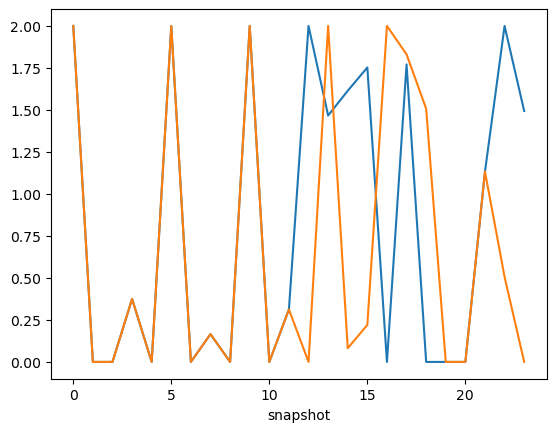

In [15]:
l.stores_t.e.sum(axis=1).plot()

n.stores_t.e.sum(axis=1).plot()

In [16]:
l.objective

886.6674802933398

In [17]:
intv = 4

In [18]:
e_final_max.iloc[1::intv, :] = e_final_min.iloc[1::intv, :]

In [19]:
up = linopy.Model()

snapshots_up = snapshots[intv-1::intv]

stores = l.stores.index

snapshots_up.name = "snapshot"

e = up.add_variables(lower=0, coords= [snapshots_up, stores], name="e")

theta = up.add_variables(lower=-1e7, name="theta")

up.add_constraints(e <=  e_nom , name="Store-e-upper")

up.add_objective(theta*1)

up.solve(solver_name="cplex")

INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.01s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 24 rows and 25 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 24 duals
Objective: -1.00e+07
Solver model: available
Solver message: optimal



('ok', 'optimal')

In [54]:
o = {}
for i in range(int(len(snapshots)/intv)):
    o[i] = partial_pypsa(
        snapshots[i*intv:i*intv+intv],
        d.loc[snapshots[i*intv:i*intv+intv]],
        e_in.loc[snapshots[i*intv:i*intv+intv]],
        e_nom,
        e_initial,
        e_final_min.loc[snapshots[i*intv:i*intv+intv]],
        e_final_max.loc[snapshots[i*intv:i*intv+intv]]
    )
    
    o[i].optimize(
        solver_name="cplex"
    )

/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.03s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 57 rows and 17 columns.
Aggregator did 16 substitutions.
Reduced LP has 3 rows, 11 columns, and 13 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           266.459205


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 2.66e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.02s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 58 rows and 21 columns.
Aggregator did 16 substitutions.
Reduced LP has 2 rows, 7 columns, and 8 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           368.040203


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 3.68e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.03s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 56 rows and 13 columns.
Aggregator did 16 substitutions.
Reduced LP has 4 rows, 15 columns, and 18 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           106.327943


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 1.06e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.03s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 56 rows and 13 columns.
Aggregator did 16 substitutions.
Reduced LP has 4 rows, 15 columns, and 18 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            50.578403


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 5.06e+01
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.02s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 56 rows and 13 columns.
Aggregator did 16 substitutions.
Reduced LP has 4 rows, 15 columns, and 18 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            32.000978


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 3.20e+01
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
/tmp/ipykernel_2048422/280965894.py:31: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd(
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
Index(['b'], dtype='object', name='Bus')
Index(['php', 'battery1', 'hydro', 'battery2'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.02s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 56 rows and 13 columns.
Aggregator did 16 substitutions.
Reduced LP has 4 rows, 15 columns, and 18 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =           244.047748


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 44 primals, 76 duals
Objective: 2.44e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [55]:
cut = {}

for i in o.keys():
    
    cut_pars = {}
    
    n = o[i]
    m = n.model

    variables = m.variables["Store-e"].labels.to_dataframe().labels

    T_p = {}
    h_p = {}
    u_p = {}

    for c in m.constraints:
        h_p[c] = m.constraints[c].rhs.to_dataframe()
        u_p[c] = m.constraints[c].dual.to_dataframe()

        T_constraint=pd.DataFrame()

        for var in variables:

            
            var_name = variables[variables == var].index.to_flat_index()[0]
            
            T_var = (
                (m.constraints[c].vars.to_dataframe().unstack("_term") == var).vars
                *1
            ).multiply(
                m.constraints[c].coeffs.to_dataframe().unstack("_term").coeffs
            ).sum(axis=1)
            
            T_var.name = var_name
            
            T_constraint = pd.concat([T_constraint, T_var], axis=1)
        
        T_p[c] = T_constraint
   

     
    prev_m = o[list(o.keys())[i-1]]
    prev_snap = prev_m.snapshots[-1]

    missing_vars = (prev_m.model.variables["Store-e"].labels
            .to_dataframe()
            .loc[[prev_snap]]
            .index
            .to_flat_index()
        )

    for mvar in missing_vars:

        missing_var = pd.Series(0., T_constraint.index)
        missing_var.loc[n.snapshots[0], mvar[1]] = 1.
        missing_var.name = mvar

        T_p["Store-energy_balance"] = pd.concat(
            [T_p["Store-energy_balance"], missing_var], 
            axis = 1
        )

    h_p["Store-energy_balance"].loc[n.snapshots[0], "rhs"] = 0
    h_p["Store-fix-e-lower"].loc[n.snapshots[-1], "rhs"] = 0
    h_p["Store-fix-e-upper"].loc[n.snapshots[-1], "rhs"] = e_nom.values
    
    u_p["Store-fix-e-lower"].loc[n.snapshots[-1], "dual"] = 0
    
    (
        u_p["Store-fix-e-upper"]
        .loc[n.snapshots[-1]]
        [h_p["Store-fix-e-upper"].loc[n.snapshots[-1]].rhs < e_nom]
    ) = 0
    
    
    cut_pars["T"] = T_p
    cut_pars["h"] = h_p
    cut_pars["u"] = u_p
    
    cut[i] = cut_pars
    

/tmp/ipykernel_2048422/2214936559.py:70: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  u_p["Store-fix-e-upper"]
/tmp/ipykernel_2048422/2214936559.py:70: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are sett

In [56]:
T_pall = {}
h_pall = {}
u_pall = {}

for c in o[i].model.constraints:

    T_pall[c] = pd.concat([cut[i]["T"][c] for i in o.keys()]).fillna(0).sort_index(axis=1)
    u_pall[c] = pd.concat([cut[i]["u"][c] for i in o.keys()]).fillna(0).sort_index(axis=1)
    h_pall[c] = pd.concat([cut[i]["h"][c] for i in o.keys()]).fillna(0).sort_index(axis=1)

In [57]:
E_p = sum(T_pall[c].multiply(u_pall[c].dual, axis=0).sum() for c in m.constraints)

In [58]:
e_p = sum(h_pall[c].rhs.multiply(u_pall[c].dual, axis=0).sum() for c in m.constraints)

In [59]:
E_p.index = pd.Index([i for i in E_p.index])

In [60]:
E_p.index.names = ["snapshot", "Store"]

In [61]:
w = e_p - e_final_min.stack().loc[snapshots_up].sort_index().multiply(E_p.loc[snapshots_up]).sum()

In [62]:
w

867.4544804887237

In [63]:
w <=theta.solution.values

True

In [64]:
up.add_constraints((e*E_p.loc[snapshots_up].to_xarray()).sum() + theta >= e_p)

Constraint `con2`
-----------------
-110 e[3, battery1] - 110 e[3, battery2] - 110 e[3, hydro] ... -100 e[23, hydro] - 100 e[23, php] + 1 theta ≥ 647.4544804887237

In [65]:
up.solve(solver_name="cplex")

INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io: Writing time: 0.02s


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 27 rows and 25 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 27 duals
Objective: 9.64e+02
Solver model: available
Solver message: optimal



('ok', 'optimal')

In [66]:
up.solution.theta

<xarray.DataArray 'theta' ()> Size: 8B
array(963.8128411)

In [67]:
l.objective

886.6674802933398

In [46]:
e_final_min = up.solution.e.to_dataframe().e.unstack("Store").reindex(l.snapshots,level=0, fill_value=0)

In [47]:
e_final_max = up.solution.e.to_dataframe().e.unstack("Store").reindex(l.snapshots,level=0)
e_final_max.fillna(e_nom, inplace=True)

In [48]:
e_initial = e_final_min.shift(1).add(
    e_final_min.shift(-len(snapshots)+1),
    fill_value=0
)
    

<Axes: xlabel='snapshot'>

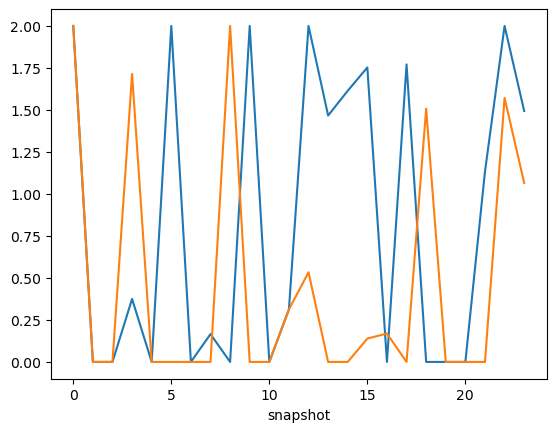

In [49]:
l.stores_t.e.sum(axis=1).plot()

pd.concat([o[i].stores_t.e for i in o.keys()]).sum(axis=1).plot()

<Axes: xlabel='snapshot'>

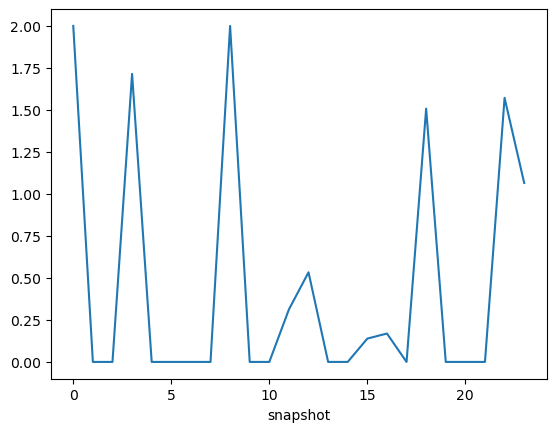

In [50]:
pd.concat([o[i].stores_t.e for i in o.keys()]).sum(axis=1).plot()

In [51]:
sum(o[i].objective for i in o.keys())

1023.8128411038698

In [52]:
l.objective

886.6674802933398

In [53]:
up.solution.theta

<xarray.DataArray 'theta' ()> Size: 8B
array(963.8128411)

In [55]:
pd.concat([o[i].generators_t.p for i in o.keys()]).multiply(o[0].generators.marginal_cost).sum()

Generator
ls       0.000000
gs     975.379300
gas    335.974541
dtype: float64

In [56]:
l.generators_t.p.multiply(l.generators.marginal_cost).sum()

Generator
ls        0.000000
gs     1091.361850
gas     301.248264
dtype: float64

In [57]:

pd.concat([o[i].loads_t.p_set for i in o.keys()]).sum(axis=1)

snapshot
0     1.722825
1     5.157636
2     1.440999
3     0.720755
4     0.059696
5     2.482042
6     0.094883
7     4.161485
8     0.413858
9     5.652926
10   -1.858192
11    1.225739
12    0.143232
13    3.290791
14    2.198676
15   -3.198812
16    2.814341
17   -1.081134
18   -2.891124
19   -3.860195
20   -3.882352
21    1.159825
22    1.888411
23    1.354897
dtype: float64

In [58]:
l.loads_t.p_set.sum(axis=1)

snapshot
0     1.722825
1     5.157636
2     1.440999
3     0.720755
4     0.059696
5     2.482042
6     0.094883
7     4.161485
8     0.413858
9     5.652926
10   -1.858192
11    1.225739
12    0.143232
13    3.290791
14    2.198676
15   -3.198812
16    2.814341
17   -1.081134
18   -2.891124
19   -3.860195
20   -3.882352
21    1.159825
22    1.888411
23    1.354897
dtype: float64

In [202]:
o[2].stores.e_initial

Store
php         0.0
battery1    0.0
hydro       0.0
battery2    0.0
Name: e_initial, dtype: float64

In [226]:
o[2].stores_t.e

Store,php,battery1,hydro,battery2
snapshot,,,,
4,0.0,-0.0,-0.0,-0.0
5,0.5,0.5,0.5,0.5


In [225]:
o[3].stores.e_initial

Store
php         0.0
battery1    0.0
hydro       0.0
battery2    0.0
Name: e_initial, dtype: float64

In [224]:
o[3].stores_t.p

Store,php,battery1,hydro,battery2
snapshot,,,,
6,-0.5,-0.5,-0.5,-0.5
7,0.5,0.5,0.5,0.5


In [221]:
l.stores_t.e.loc[[6,7]]

Store,php,battery1,hydro,battery2
snapshot,,,,
6,0.5,0.5,0.5,0.5
7,0.0,-0.0,0.0,0.0


In [208]:
l.generators_t.p.loc[[4,5]]

Generator,ls,gs,gas
snapshot,,,
4,-0.0,-0.0,4.0
5,-0.0,-2.0,-0.0


In [197]:

o[1].stores_t.p.sum().sum()

2.0

In [196]:
o[1].generators_t.p.sum().sum()

3.0

In [198]:
l.stores_t.p.iloc[2:4].sum().sum()

2.0

In [199]:
l.generators_t.p.iloc[2:4].sum().sum()

3.0

In [177]:

pd.concat([o[i].stores_t.e for i in o.keys()]).sum(axis=1)

snapshot
0    1.0
1    2.0
2    2.0
3    0.0
4    0.0
5    2.0
6    2.0
7    0.0
dtype: float64

In [174]:
l.stores_t.p.sum().sum()

0.0